<a href="https://colab.research.google.com/github/SidouPrince/Cpp/blob/master/classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**INSTALLATION**

# cloths_classification

#clothing classification with `fashion-mnist`


| Label number | Label name  |
|--------------|-------------|
| 0	           | T-shirt/top |
| 1	           | Trouser     |
| 2	           | Pullover    |
| 3	           | Dress       |
| 4	           | Coat        |
| 5	           | Sandal      |
| 6	           | Shirt       |
| 7	           | Sneaker     |
| 8	           | Bag         |
| 9	           | Ankle boot  |

**IMPORTATION**

In [60]:
import os, re, math, json, shutil, pprint
from tensorflow.keras import backend as K
import PIL.Image, PIL.ImageFont, PIL.ImageDraw
import IPython.display as display
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
print("Tensorflow version " + tf.__version__)

Tensorflow version 2.3.0


# DATA LOADING
pour commencer, on va charger le dataFram 

**Parametres**


In [2]:
BATCH_SIZE = 128
EPOCHS = 10 

In [4]:
#@title visualization utilities [RUN ME]
"""
This cell contains helper functions used for visualization
and downloads only. You can skip reading it. There is very
little useful Keras/Tensorflow code here.
"""

# Matplotlib config
plt.ioff()
plt.rc('image', cmap='gray_r')
plt.rc('grid', linewidth=1)
plt.rc('xtick', top=False, bottom=False, labelsize='large')
plt.rc('ytick', left=False, right=False, labelsize='large')
plt.rc('axes', facecolor='F8F8F8', titlesize="large", edgecolor='white')
plt.rc('text', color='a8151a')
plt.rc('figure', facecolor='F0F0F0', figsize=(16,9))
# Matplotlib fonts
MATPLOTLIB_FONT_DIR = os.path.join(os.path.dirname(plt.__file__), "mpl-data/fonts/ttf")

# pull a batch from the datasets. This code is not very nice, it gets much better in eager mode (TODO)
def dataset_to_numpy_util(training_dataset, validation_dataset, N):
  
  # get one batch from each: 10000 validation digits, N training digits
  batch_train_ds = training_dataset.unbatch().batch(N)
  
  # eager execution: loop through datasets normally
  if tf.executing_eagerly():
    for validation_digits, validation_labels in validation_dataset:
      validation_digits = validation_digits.numpy()
      validation_labels = validation_labels.numpy()
      break
    for training_digits, training_labels in batch_train_ds:
      training_digits = training_digits.numpy()
      training_labels = training_labels.numpy()
      break
    
  else:
    v_images, v_labels = validation_dataset.make_one_shot_iterator().get_next()
    t_images, t_labels = batch_train_ds.make_one_shot_iterator().get_next()
    # Run once, get one batch. Session.run returns numpy results
    with tf.Session() as ses:
      (validation_digits, validation_labels,
       training_digits, training_labels) = ses.run([v_images, v_labels, t_images, t_labels])
  
  # these were one-hot encoded in the dataset
  validation_labels = np.argmax(validation_labels, axis=1)
  training_labels = np.argmax(training_labels, axis=1)
  
  return (training_digits, training_labels,
          validation_digits, validation_labels)

# create digits from local fonts for testing
def create_digits_from_local_fonts(n):
  font_labels = []
  img = PIL.Image.new('LA', (28*n, 28), color = (0,255)) # format 'LA': black in channel 0, alpha in channel 1
  font1 = PIL.ImageFont.truetype(os.path.join(MATPLOTLIB_FONT_DIR, 'DejaVuSansMono-Oblique.ttf'), 25)
  font2 = PIL.ImageFont.truetype(os.path.join(MATPLOTLIB_FONT_DIR, 'STIXGeneral.ttf'), 25)
  d = PIL.ImageDraw.Draw(img)
  for i in range(n):
    font_labels.append(i%10)
    d.text((7+i*28,0 if i<10 else -4), str(i%10), fill=(255,255), font=font1 if i<10 else font2)
  font_digits = np.array(img.getdata(), np.float32)[:,0] / 255.0 # black in channel 0, alpha in channel 1 (discarded)
  font_digits = np.reshape(np.stack(np.split(np.reshape(font_digits, [28, 28*n]), n, axis=1), axis=0), [n, 28*28])
  return font_digits, font_labels

# utility to display a row of digits with their predictions
def display_digits(digits, predictions, labels, title, n):
  fig = plt.figure(figsize=(13,3))
  digits = np.reshape(digits, [n, 28, 28])
  digits = np.swapaxes(digits, 0, 1)
  digits = np.reshape(digits, [28, 28*n])
  plt.yticks([])
  plt.xticks([28*x+14 for x in range(n)], predictions)
  plt.grid(b=None)
  for i,t in enumerate(plt.gca().xaxis.get_ticklabels()):
    if predictions[i] != labels[i]: t.set_color('red') # bad predictions in red
  plt.imshow(digits)
  plt.grid(None)
  plt.title(title)
  display.display(fig)
  
# utility to display multiple rows of digits, sorted by unrecognized/recognized status
def display_top_unrecognized(digits, predictions, labels, n, lines):
  idx = np.argsort(predictions==labels) # sort order: unrecognized first
  for i in range(lines):
    display_digits(digits[idx][i*n:(i+1)*n], predictions[idx][i*n:(i+1)*n], labels[idx][i*n:(i+1)*n],
                   "{} sample validation digits out of {} with bad predictions in red and sorted first".format(n*lines, len(digits)) if i==0 else "", n)

def plot_learning_rate(lr_func, epochs):
  xx = np.arange(epochs+1, dtype=np.float)
  y = [lr_decay(x) for x in xx]
  fig, ax = plt.subplots(figsize=(9, 6))
  ax.set_xlabel('epochs')
  ax.set_title('Learning rate\ndecays from {:0.3g} to {:0.3g}'.format(y[0], y[-2]))
  ax.minorticks_on()
  ax.grid(True, which='major', axis='both', linestyle='-', linewidth=1)
  ax.grid(True, which='minor', axis='both', linestyle=':', linewidth=0.5)
  ax.step(xx,y, linewidth=3, where='post')
  display.display(fig)

class PlotTraining(tf.keras.callbacks.Callback):
  def __init__(self, sample_rate=1, zoom=1):
    self.sample_rate = sample_rate
    self.step = 0
    self.zoom = zoom
    self.steps_per_epoch = 60000//BATCH_SIZE

  def on_train_begin(self, logs={}):
    self.batch_history = {}
    self.batch_step = []
    self.epoch_history = {}
    self.epoch_step = []
    self.fig, self.axes = plt.subplots(1, 2, figsize=(16, 7))
    plt.ioff()

  def on_batch_end(self, batch, logs={}):
    if (batch % self.sample_rate) == 0:
      self.batch_step.append(self.step)
      for k,v in logs.items():
        # do not log "batch" and "size" metrics that do not change
        # do not log training accuracy "acc"
        if k=='batch' or k=='size':# or k=='acc':
          continue
        self.batch_history.setdefault(k, []).append(v)
    self.step += 1

  def on_epoch_end(self, epoch, logs={}):
    plt.close(self.fig)
    self.axes[0].cla()
    self.axes[1].cla()
      
    self.axes[0].set_ylim(0, 1.2/self.zoom)
    self.axes[1].set_ylim(1-1/self.zoom/2, 1+0.1/self.zoom/2)
    
    self.epoch_step.append(self.step)
    for k,v in logs.items():
      # only log validation metrics
      if not k.startswith('val_'):
        continue
      self.epoch_history.setdefault(k, []).append(v)

    display.clear_output(wait=True)
    
    for k,v in self.batch_history.items():
      self.axes[0 if k.endswith('loss') else 1].plot(np.array(self.batch_step) / self.steps_per_epoch, v, label=k)
      
    for k,v in self.epoch_history.items():
      self.axes[0 if k.endswith('loss') else 1].plot(np.array(self.epoch_step) / self.steps_per_epoch, v, label=k, linewidth=3)
      
    self.axes[0].legend()
    self.axes[1].legend()
    self.axes[0].set_xlabel('epochs')
    self.axes[1].set_xlabel('epochs')
    self.axes[0].minorticks_on()
    self.axes[0].grid(True, which='major', axis='both', linestyle='-', linewidth=1)
    self.axes[0].grid(True, which='minor', axis='both', linestyle=':', linewidth=0.5)
    self.axes[1].minorticks_on()
    self.axes[1].grid(True, which='major', axis='both', linestyle='-', linewidth=1)
    self.axes[1].grid(True, which='minor', axis='both', linestyle=':', linewidth=0.5)
    display.display(self.fig)

In [13]:
# Number of classes
num_classes = 10
# input image dimensions
img_rows, img_cols = 28, 28

# the data, shuffled and split between train and test sets
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

In [109]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

# Preprocess the data (these are NumPy arrays)
x_train = x_train.reshape(60000, 784).astype("float32") / 255
x_test = x_test.reshape(10000, 784).astype("float32") / 255

y_train = y_train.astype("float32")
y_test = y_test.astype("float32")

# Reserve 10,000 samples for validation
x_val = x_train[-10000:]
y_val = y_train[-10000:]
x_train = x_train[:-10000]
y_train = y_train[:-10000]


In [110]:
x_train.shape

(50000, 784)

In [111]:
y_train.shape

(50000,)

In [69]:
x_test.shape

(10000, 784)

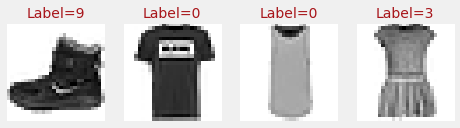

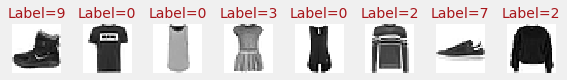

In [74]:

plt.figure(figsize=(8, 2))
for i in range(8):
    plt.subplot(1, 8, i+1)
    plt.imshow(x_train[i].reshape(28, 28), 
               interpolation="none", cmap="gray_r")
    plt.title('Label=%d' % y_train[i], fontsize=14)
    plt.axis("off")
plt.tight_layout()
plt.show()


## 1.4. Normalization and preprocessing of the data

We need to normalize the images and one-hot encode the labels.

In [113]:
# convert class vectors to binary class matrices
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)
y_val = to_categorical(y_val, num_classes)

In [99]:
y_train.shape

(50000, 10)

In [100]:
y_test.shape

(10000, 10)

### Keras Premier modele simple

Une seule couche dense

In [107]:
inputs = tf.keras.Input(shape=(784,), name="digits")
outputs = tf.keras.layers.Dense(10, activation="softmax", name="predictions")(inputs)

model = tf.keras.Model(inputs=inputs, outputs=outputs)




model.compile(optimizer='sgd',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# print model layers
model.summary()

#utility callback that displays training curves
plot_training = PlotTraining(sample_rate=10, zoom=1)

Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
digits (InputLayer)          [(None, 784)]             0         
_________________________________________________________________
predictions (Dense)          (None, 10)                7850      
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
_________________________________________________________________


### Train and validate the model

In [84]:
steps_per_epoch = 60000//BATCH_SIZE  # 60,000 items in this dataset


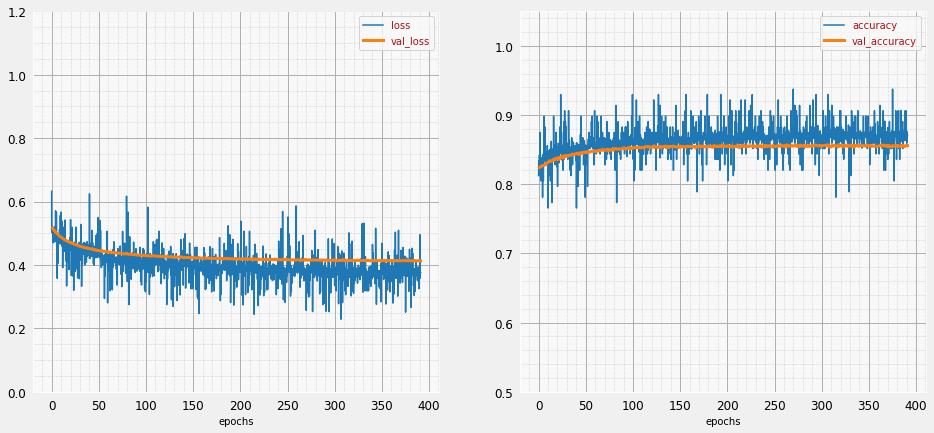

391/391 [==============================] - 5s 13ms/step - loss: 0.3754 - accuracy: 0.8708 - val_loss: 0.4126 - val_accuracy: 0.8559


In [117]:
tf.config.experimental_run_functions_eagerly(True)
print("Fit model on training data")
history = model.fit(
    x_train,
    y_train,
    batch_size=BATCH_SIZE,
    epochs=steps_per_epoch,
    # We pass some validation for
    # monitoring validation loss and metrics
    # at the end of each epoch
    validation_data=(x_val, y_val),
    validation_steps=1,
    
    callbacks=[plot_training],

    # We pass some validation for
    # monitoring validation loss and metrics
    # at the end of each epoch
)
